In [156]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import pandas as pd
import numpy as np

In [157]:
# !pip install rasterio

In [158]:
stations_df = pd.read_csv('data/stations_with_conditions.csv')
glorich_df = pd.read_csv('data/final_imputed_hydrochem.csv')
landsat_df = pd.read_csv('data/train+LandsatAPI.csv')

In [159]:
def df_to_gdf(df):
    df["geometry"] = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [160]:
landsat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Latitude                       9319 non-null   float64
 1   Longitude                      9319 non-null   float64
 2   Sample Date                    9319 non-null   object 
 3   Total Alkalinity               9319 non-null   float64
 4   Electrical Conductance         9319 non-null   float64
 5   Dissolved Reactive Phosphorus  9319 non-null   float64
 6   pet                            9319 non-null   float64
 7   _merge_terra                   9319 non-null   object 
 8   nir                            9319 non-null   float64
 9   green                          9319 non-null   float64
 10  swir16                         9319 non-null   float64
 11  swir22                         9319 non-null   float64
 12  NDMI                           9319 non-null   f

In [161]:
stations_gdf = df_to_gdf(stations_df)
landsat_gdf = df_to_gdf(landsat_df)

In [162]:
# !pip install contextily

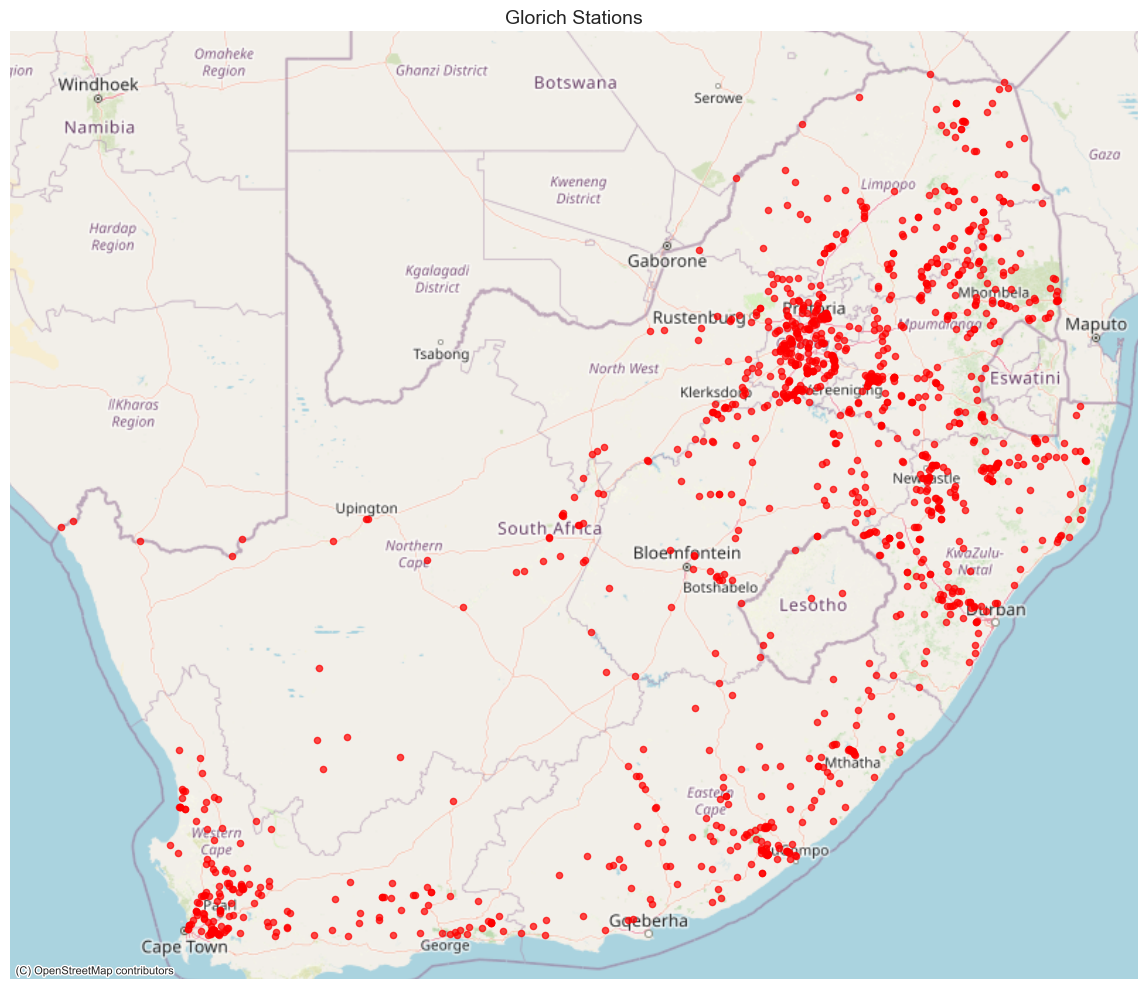

In [163]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # pip install contextily — adds a basemap


# ── Static plot with basemap ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 10))

stations_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    color='red',
    markersize=20,
    alpha=0.7,
    label='Stations'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Glorich Stations", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

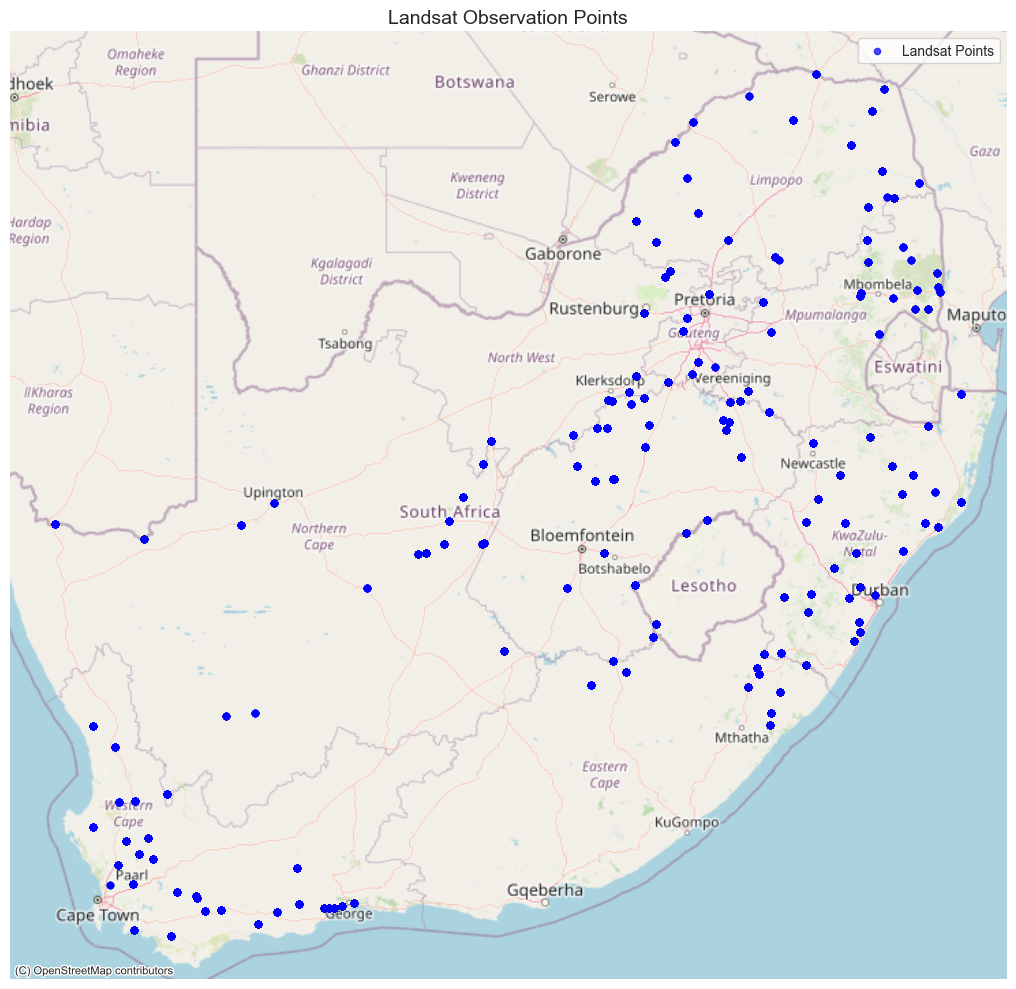

In [164]:
fig, ax = plt.subplots(figsize=(12, 10))

landsat_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    color='blue',
    markersize=20,
    alpha=0.7,
    label='Landsat Points'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Landsat Observation Points", fontsize=14)
ax.set_axis_off()
plt.legend()
plt.tight_layout()
plt.show()

In [165]:
stations_m = stations_gdf.to_crs(epsg=3857)
landsat_m  = landsat_gdf.to_crs(epsg=3857)

landsat_to_station = gpd.sjoin_nearest(
    landsat_m, # LEFT: each landsat point
    stations_m,  # RIGHT: station candidates
    how="left",
    distance_col="dist_m"
)

landsat_to_station["dist_km"] = landsat_to_station["dist_m"] / 1000
landsat_to_station = landsat_to_station.rename(columns= {'Latitude_left': 'Latitude', 'Longitude_left': 'Longitude', 'Latitude_right': 'Latitude_stations', 'Longitude_right': 'Longitude_stations'})

landsat_to_station.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,pet,_merge_terra,nir,green,...,GLC_Managed,GLC_Water,GLC_Aquatic_Veg,GLC_PERC_COV,Popdens_00,Soil_pH,SOC,Soil_wetness,dist_m,dist_km
0,-34.40583,19.60056,2011-07-06,35.054,1224.0,10.0,158.7,both,9226.0,8526.0,...,0.04,0.0,0.0,100.0,4.67,6.48,3.81,40.74,61065.578594,61.065579
1,-34.40583,19.60056,2011-08-02,36.247,1237.0,10.0,174.1,both,17890.0,10536.0,...,0.04,0.0,0.0,100.0,4.67,6.48,3.81,40.74,61065.578594,61.065579
2,-34.40583,19.60056,2011-08-30,37.607,1034.0,10.0,174.1,both,6635.5,4251.0,...,0.04,0.0,0.0,100.0,4.67,6.48,3.81,40.74,61065.578594,61.065579
3,-34.40583,19.60056,2011-09-27,27.082,929.0,108.0,174.1,both,18317.0,9145.5,...,0.04,0.0,0.0,100.0,4.67,6.48,3.81,40.74,61065.578594,61.065579
4,-34.40583,19.60056,2011-10-27,40.357,1245.0,10.0,174.1,both,18317.0,9145.5,...,0.04,0.0,0.0,100.0,4.67,6.48,3.81,40.74,61065.578594,61.065579


In [166]:
landsat_to_station.to_csv('data/landsat_to_station.csv', index=False)

## Adding hydrochem properties to the station data

In [167]:
glorich_df.tail()

,STAT_ID,Latitude,Longitude,date,Alkalinity,Cl,DIP,SO4,SpecCond25C,pH,Alkalinity_reliability,Cl_reliability,DIP_reliability,SO4_reliability,SpecCond25C_reliability,pH_reliability
110920,401573,-27.66,25.61,2015-10-15,2216.146886,1551.622,1.048448,1489.069,67.1,7.181231,1.0,0.4,1.0,0.4,0.4,0.7
110921,401573,-27.66,25.61,2015-11-01,2216.146886,1551.622,1.048448,1489.069,67.1,7.181231,1.0,0.4,1.0,0.4,0.4,0.7
110922,401573,-27.66,25.61,2015-11-15,2216.146886,1551.622,1.048448,1489.069,67.1,7.181231,1.0,0.4,1.0,0.4,0.4,0.7
110923,401573,-27.66,25.61,2015-12-01,2216.146886,1551.622,1.048448,1489.069,67.1,7.181231,1.0,0.4,1.0,0.4,0.4,0.7
110924,401573,-27.66,25.61,2015-12-15,2216.146886,1551.622,1.048448,1489.069,67.1,7.181231,1.0,0.4,1.0,0.4,0.4,0.7


In [168]:
glorich_df['date'] = pd.to_datetime(glorich_df['date'], format='%Y-%m-%d')
glorich_df['date'].describe()

count                 110640
mean     2013-06-23 06:24:00
min      2011-01-01 00:00:00
25%      2012-03-27 18:00:00
50%      2013-06-23 00:00:00
75%      2014-09-19 00:00:00
max      2015-12-15 00:00:00
Name: date, dtype: object

In [169]:
glorich_df = glorich_df.sort_values('SpecCond25C_reliability', ascending=False).drop_duplicates(subset=['Latitude', 'Longitude', 'date'], keep='first')

In [170]:
glorich_df.columns

Index(['STAT_ID', 'Latitude', 'Longitude', 'date', 'Alkalinity', 'Cl', 'DIP',
       'SO4', 'SpecCond25C', 'pH', 'Alkalinity_reliability', 'Cl_reliability',
       'DIP_reliability', 'SO4_reliability', 'SpecCond25C_reliability',
       'pH_reliability'],
      dtype='object')

In [171]:
landsat_to_station['Sample Date'] = pd.to_datetime(
    landsat_to_station['Sample Date'], format='%Y-%m-%d'
)
landsat_to_station['Sample Date'].describe()

count                            10225
mean     2013-08-06 10:23:02.259168768
min                2011-01-02 00:00:00
25%                2012-06-14 00:00:00
50%                2013-08-27 00:00:00
75%                2014-10-14 00:00:00
max                2015-12-31 00:00:00
Name: Sample Date, dtype: object

In [172]:
# ── 3. merge_asof requires both frames sorted by the date key ────────────────
glorich_with_date = glorich_df.dropna(subset=['date'])
landsat_sorted  = landsat_to_station.sort_values('Sample Date').reset_index(drop=True)
glorich_sorted  = glorich_with_date.sort_values('date').reset_index(drop=True)

# ── 4. Nearest-date join, matched within the same station ───────────────────
#   • direction='nearest'  → picks the glorich row whose date is closest
#     (before OR after) to the landsat observation date
#   • by='STAT_ID'         → only considers glorich rows for the same station
#   • how='left' is implicit in merge_asof; stations with no glorich data
#     will get NaN for all glorich columns (your case 3) ───────────────────

merged = pd.merge_asof(
    landsat_sorted,
    glorich_sorted,
    left_on='Sample Date',
    right_on='date',
    by='STAT_ID',
    direction='nearest',
    suffixes=('_landsat', '_glorich')
)

In [173]:
merged['date_diff_days'] = (
    merged['Sample Date'] - merged['date']
).dt.days.abs()

merged.head()

,Latitude_landsat,Longitude_landsat,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,pet,_merge_terra,nir,green,...,SO4,SpecCond25C,pH,Alkalinity_reliability,Cl_reliability,DIP_reliability,SO4_reliability,SpecCond25C_reliability,pH_reliability,date_diff_days
0,-28.76083,17.73028,2011-01-02,128.912,555.0,10.0,174.2,both,11190.0,11426.0,...,426.872176,30.440000,7.904400,0.4,0.4,1.0,1.0,0.4,0.4,1.0
1,-26.45000,28.08583,2011-01-03,89.254,573.0,80.0,127.5,both,15210.0,10720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-27.35667,27.28639,2011-01-03,56.100,145.1,151.0,129.2,both,16828.5,9502.5,...,324.518060,21.350789,7.569425,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,-26.86111,28.88472,2011-01-03,74.720,162.9,163.0,124.1,both,17658.5,9550.0,...,651.088335,57.604498,7.800000,1.0,1.0,0.4,1.0,1.0,0.4,2.0
4,-26.45000,28.08583,2011-01-03,89.254,573.0,80.0,127.5,both,15210.0,10720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
merged.drop(columns=['index_right', 'Latitude_stations', 'Longitude_stations'], inplace=True)


In [175]:
merged = merged.rename(columns={'Latitude_landsat': 'Latitude', 'Longitude_landsat': 'Longitude'})

In [176]:
merged.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,pet,_merge_terra,nir,green,...,SO4,SpecCond25C,pH,Alkalinity_reliability,Cl_reliability,DIP_reliability,SO4_reliability,SpecCond25C_reliability,pH_reliability,date_diff_days
0,-28.76083,17.73028,2011-01-02,128.912,555.0,10.0,174.2,both,11190.0,11426.0,...,426.872176,30.440000,7.904400,0.4,0.4,1.0,1.0,0.4,0.4,1.0
1,-26.45000,28.08583,2011-01-03,89.254,573.0,80.0,127.5,both,15210.0,10720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-27.35667,27.28639,2011-01-03,56.100,145.1,151.0,129.2,both,16828.5,9502.5,...,324.518060,21.350789,7.569425,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,-26.86111,28.88472,2011-01-03,74.720,162.9,163.0,124.1,both,17658.5,9550.0,...,651.088335,57.604498,7.800000,1.0,1.0,0.4,1.0,1.0,0.4,2.0
4,-26.45000,28.08583,2011-01-03,89.254,573.0,80.0,127.5,both,15210.0,10720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
# there are duplicate values. 
merged = (
    merged
    .sort_values('SpecCond25C_reliability', ascending=False)
    .drop_duplicates(subset=['Latitude', 'Longitude', 'Sample Date'], keep='first')
)

In [183]:
merged.isna().sum()


Latitude                           0
Longitude                          0
Sample Date                        0
Total Alkalinity                   0
Electrical Conductance             0
Dissolved Reactive Phosphorus      0
pet                                0
_merge_terra                       0
nir                                0
green                              0
swir16                             0
swir22                             0
NDMI                               0
MNDWI                              0
_merge_landsat                     0
Impute_Method                      0
geometry                           0
STAT_ID                            0
sc                                 0
ss                                 0
su                                 0
mt                                 0
va                                 0
vb                                 0
vi                                 0
pa                                 0
pb                                 0
p

In [184]:
len(merged)

9319

In [188]:
landsat_ids = set(landsat_sorted['STAT_ID'].unique())
glorich_ids = set(glorich_with_date['STAT_ID'].unique())

print("Landsat STAT_IDs:  ", len(landsat_ids))
print("Glorich STAT_IDs:  ", len(glorich_ids))
print("Overlapping IDs:   ", len(landsat_ids & glorich_ids))
print()
print("Sample landsat IDs:", sorted(landsat_ids)[:10])
print("Sample glorich IDs:", sorted(glorich_ids)[:10])

Landsat STAT_IDs:   160
Glorich STAT_IDs:   876
Overlapping IDs:    134

Sample landsat IDs: [np.int64(400011), np.int64(400045), np.int64(400075), np.int64(400229), np.int64(400444), np.int64(400445), np.int64(400446), np.int64(400447), np.int64(400448), np.int64(400449)]
Sample glorich IDs: [np.int64(400020), np.int64(400021), np.int64(400022), np.int64(400023), np.int64(400024), np.int64(400025), np.int64(400026), np.int64(400027), np.int64(400028), np.int64(400029)]


In [189]:
merged.columns

Index(['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'pet',
       '_merge_terra', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI',
       '_merge_landsat', 'Impute_Method', 'geometry', 'STAT_ID', 'sc', 'ss',
       'su', 'mt', 'va', 'vb', 'vi', 'pa', 'pb', 'pi', 'GLC_Artificial',
       'GLC_Managed', 'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV',
       'Popdens_00', 'Soil_pH', 'SOC', 'Soil_wetness', 'dist_m', 'dist_km',
       'Latitude_glorich', 'Longitude_glorich', 'date', 'Alkalinity', 'Cl',
       'DIP', 'SO4', 'SpecCond25C', 'pH', 'Alkalinity_reliability',
       'Cl_reliability', 'DIP_reliability', 'SO4_reliability',
       'SpecCond25C_reliability', 'pH_reliability', 'date_diff_days'],
      dtype='object')

In [191]:
merged.to_csv('data/training_ALL.csv', index=False)